In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/creditcardfraud/creditcard.csv


<h1 style="text-align:center; color:#0566D5; font-weight:bold; font-size:38px;">Credit Card Fraud Detection</h1>

# Credit Card Fraud Detection: Anomaly Detection Approach

Credit card fraud is a serious issue, and detecting it quickly is essential. While many machine learning models rely on supervised learning, **anomaly detection** can often be more effective for fraud detection because fraudulent transactions are rare, and there is often limited labeled data available for training.

---

## Difference Between Supervised Learning and Anomaly Detection:

1. **Supervised Learning**:  
   - Relies on labeled data, where the model learns patterns from both normal and fraudulent transactions.  
   - Works well when the dataset is balanced with sufficient examples of all classes.  
   - **Challenges**: Fraudulent transactions are rare, leading to highly imbalanced datasets. This makes the model effective at identifying normal transactions but less accurate at detecting fraud.

2. **Anomaly Detection**:  
   - Does not require a large number of fraudulent examples. Instead, it learns the "normal" behavior and flags transactions that deviate significantly from this norm.  
   - Suitable for datasets with rare events like fraud.  
   - **Advantages**:  
      - Can adapt to new types of fraud without needing examples of them.  
      - Requires less labeled data, making it scalable and efficient.

---

## Why Use Anomaly Detection?
- **Handling Rare Events**: Fraud is uncommon, and anomaly detection excels at identifying rare occurrences.  
- **Adapting to New Fraud Tactics**: By focusing on unusual patterns, anomaly detection can detect new types of fraud.  
- **Less Labeled Data Required**: Unlike supervised learning, anomaly detection does not rely heavily on labeled data, making it faster and more scalable for fraud detection.

---

## Popular Anomaly Detection Algorithms:
1. **Isolation Forest**: Identifies outliers by isolating individual points, making it efficient for large datasets.  
2. **One-Class SVM**: Models the normal transaction space and flags anything deviating from it as anomalous.  
3. **Autoencoders**: Neural networks trained to reconstruct normal transactions. Poor reconstruction performance indicates anomalies.  
4. **Local Outlier Factor (LOF)**: Measures the density of transactions and identifies those with significantly lower densities as outliers.  
5. **DBSCAN**: Groups transactions into clusters and flags those that do not belong to any cluster as potential fraud.

---

## Dataset Description: Credit Card Fraud Detection Data
This dataset contains credit card transaction data from European cardholders collected in September 2013. It is well-suited for anomaly detection and clustering techniques to identify fraudulent transactions.

### Features:
1. **Time**:  
   The elapsed time (in seconds) since the first transaction in the dataset.

2. **V1 to V28**:  
   Anonymized features derived using Principal Component Analysis (PCA) for confidentiality.

3. **Amount**:  
   The transaction amount, which can provide insights into identifying anomalies.

4. **Class**:  
   The target variable:  
   - `0`: Non-fraudulent transactions.  
   - `1`: Fraudulent transactions.  
   *(Primarily used for evaluation in unsupervised methods.)*



<h1 style="text-align:left; color:#0566D5; font-weight:bold; font-size:28px; font-family:Arial, sans-serif;">Import Libraries</h1>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

<h1 style="text-align:left; color:#0566D5; font-weight:bold; font-size:28px; font-family:Arial, sans-serif;">Remove Warnings</h1>


In [3]:
import warnings
warnings.filterwarnings('ignore')

<a id="1"></a>
# <div style="text-align:center; border-radius:25px 70px; padding:9px; color:white; margin:0; font-size:150%; font-family:Pacifico; background-color:#0566D5; overflow:hidden"><b>Reading and Understading our Data</b></div>

In [4]:
df = pd.read_csv("/kaggle/input/creditcardfraud/creditcard.csv")

In [5]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
df.shape

(284807, 31)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

- **there isn't missing value**
- **there isn't mistake datatype**

<a id="1"></a>
# <div style="text-align:center; border-radius:25px 70px; padding:9px; color:white; margin:0; font-size:150%; font-family:Pacifico; background-color:#0566D5; overflow:hidden"><b>Exploratory Data Analysis</b></div>

## Check missing value

In [8]:
df.isna().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

## Distribution of a Target Variable

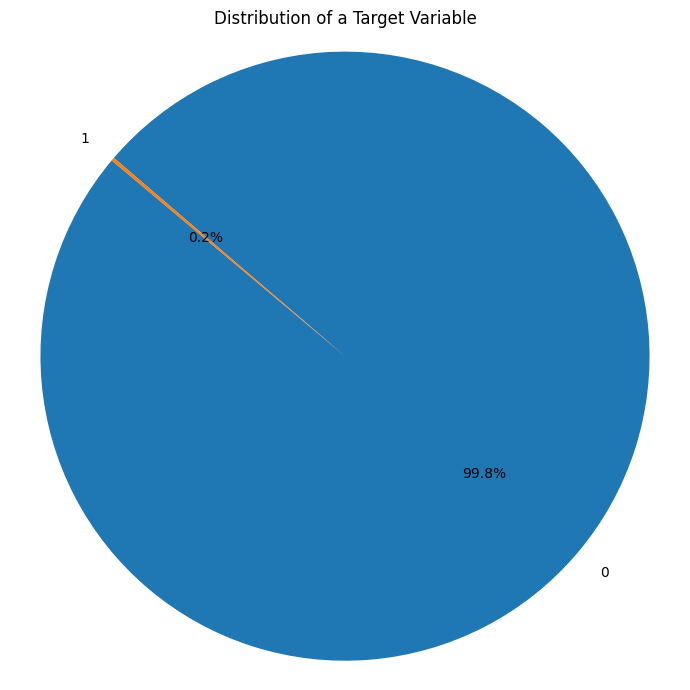

In [9]:
counts = df.Class.value_counts()


plt.figure(figsize=(7, 7))
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', 
        startangle=140)

plt.title('Distribution of a Target Variable')
plt.axis('equal')  

plt.tight_layout()
plt.show()

- We observe that anomalies (fraudulent transactions) represent only **0.2% of the dataset**.

## Distribution of Features

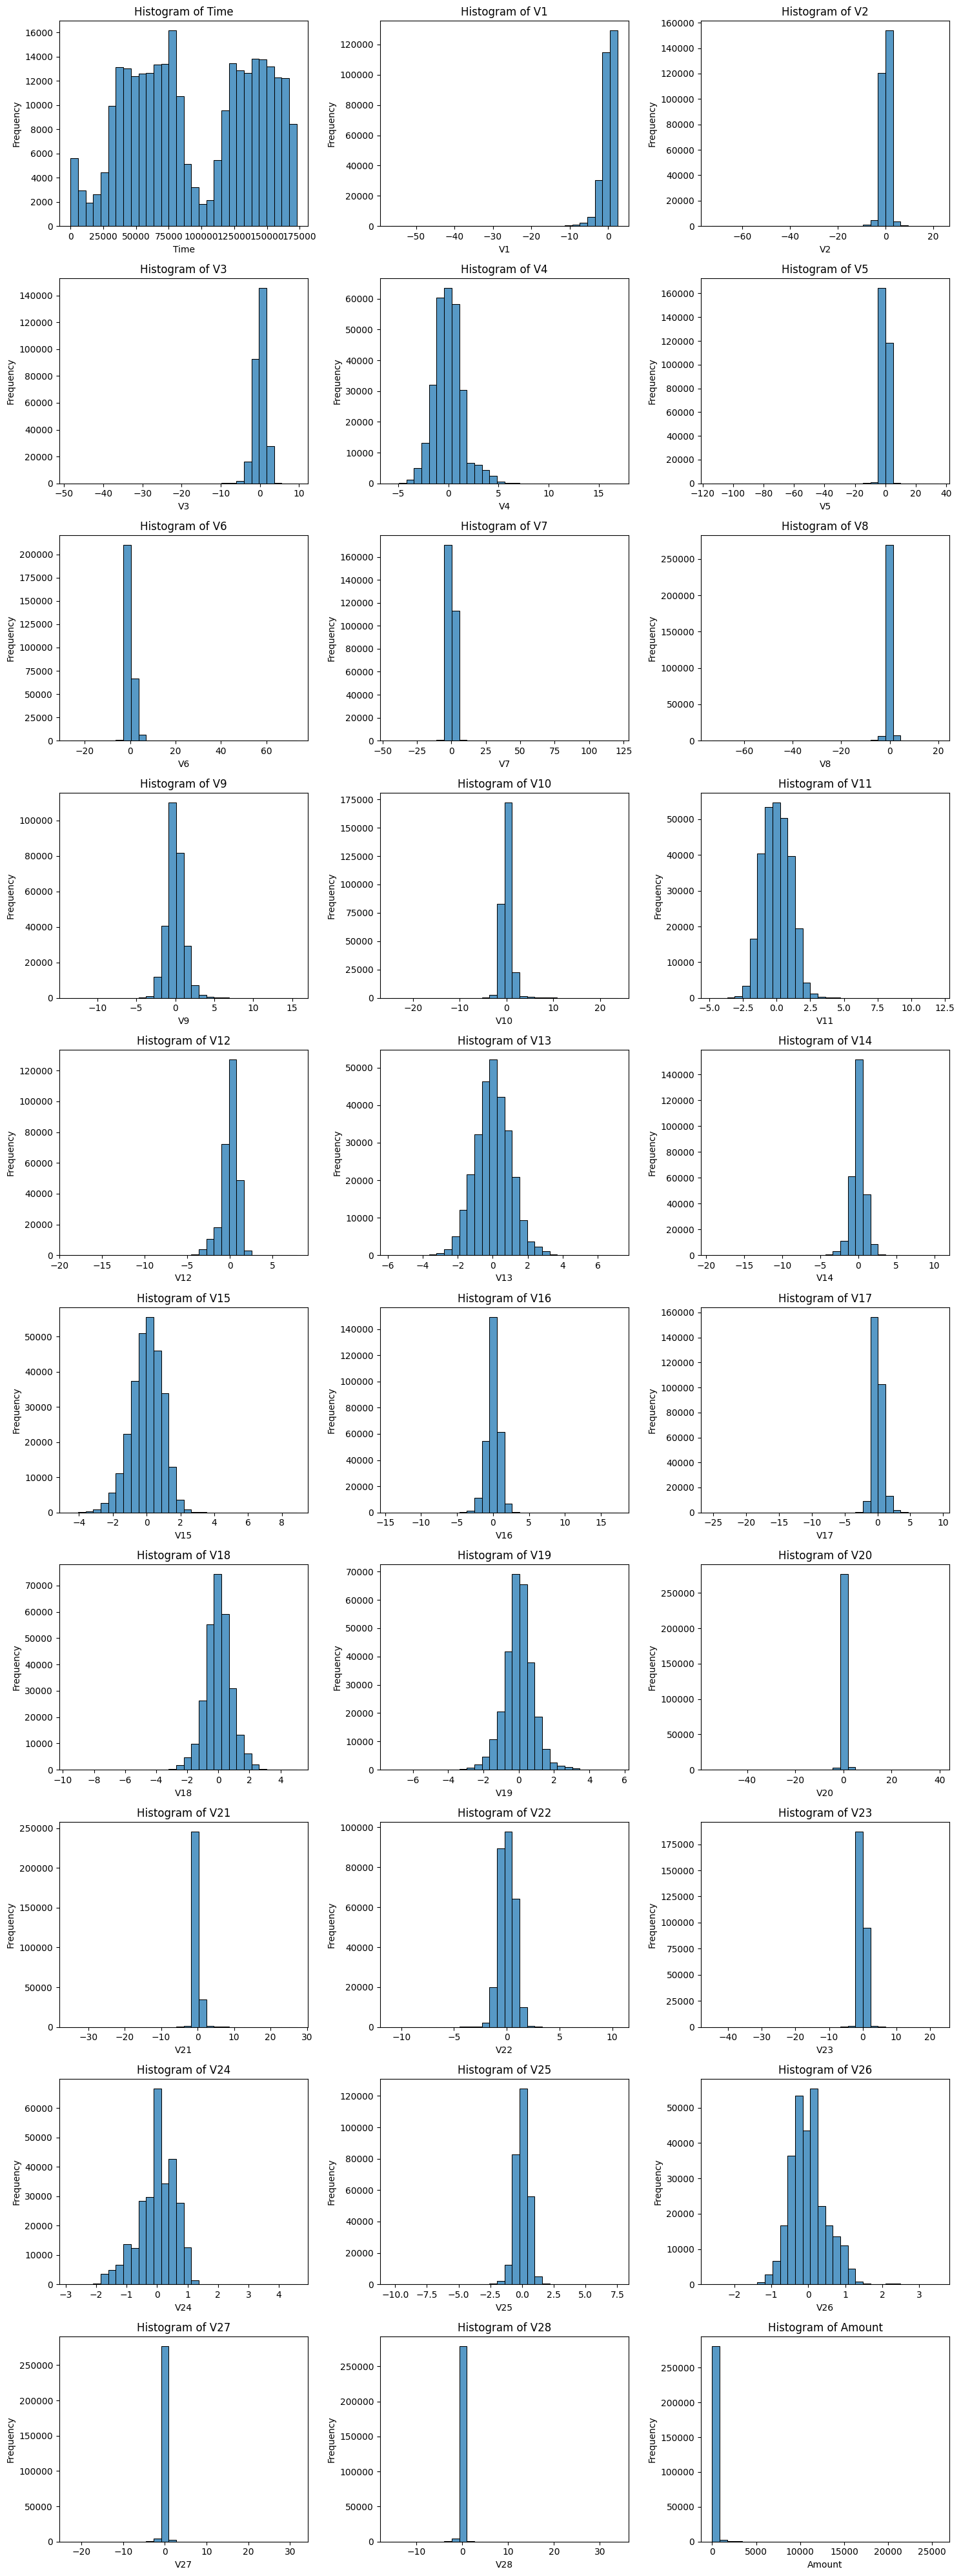

In [10]:
features = df.columns[:-1]


fig, axes = plt.subplots(10, 3, figsize=(15, 40))  

# Flatten axes array to loop through easily
axes = axes.flatten()


for i, feature in enumerate(features):
    sns.histplot(df[feature], ax=axes[i], kde=False, bins=30)
    axes[i].set_title(f'Histogram of {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

- **As we observe, some features exhibit skewness and may need to be transformed.**

Lets transform the remaining features using PCA.

In [11]:
cols= df[['Time', 'Amount']]

pca = PCA()
pca.fit(cols)
X_PCA = pca.transform(cols)

df['V29']=X_PCA[:,0]
df['V30']=X_PCA[:,1]

df.drop(['Time', 'Amount'], axis=1, inplace=True)

<a id="1"></a>
# <div style="text-align:center; border-radius:25px 70px; padding:9px; color:white; margin:0; font-size:150%; font-family:Pacifico; background-color:#0566D5; overflow:hidden"><b>Feature Selection</b></div>

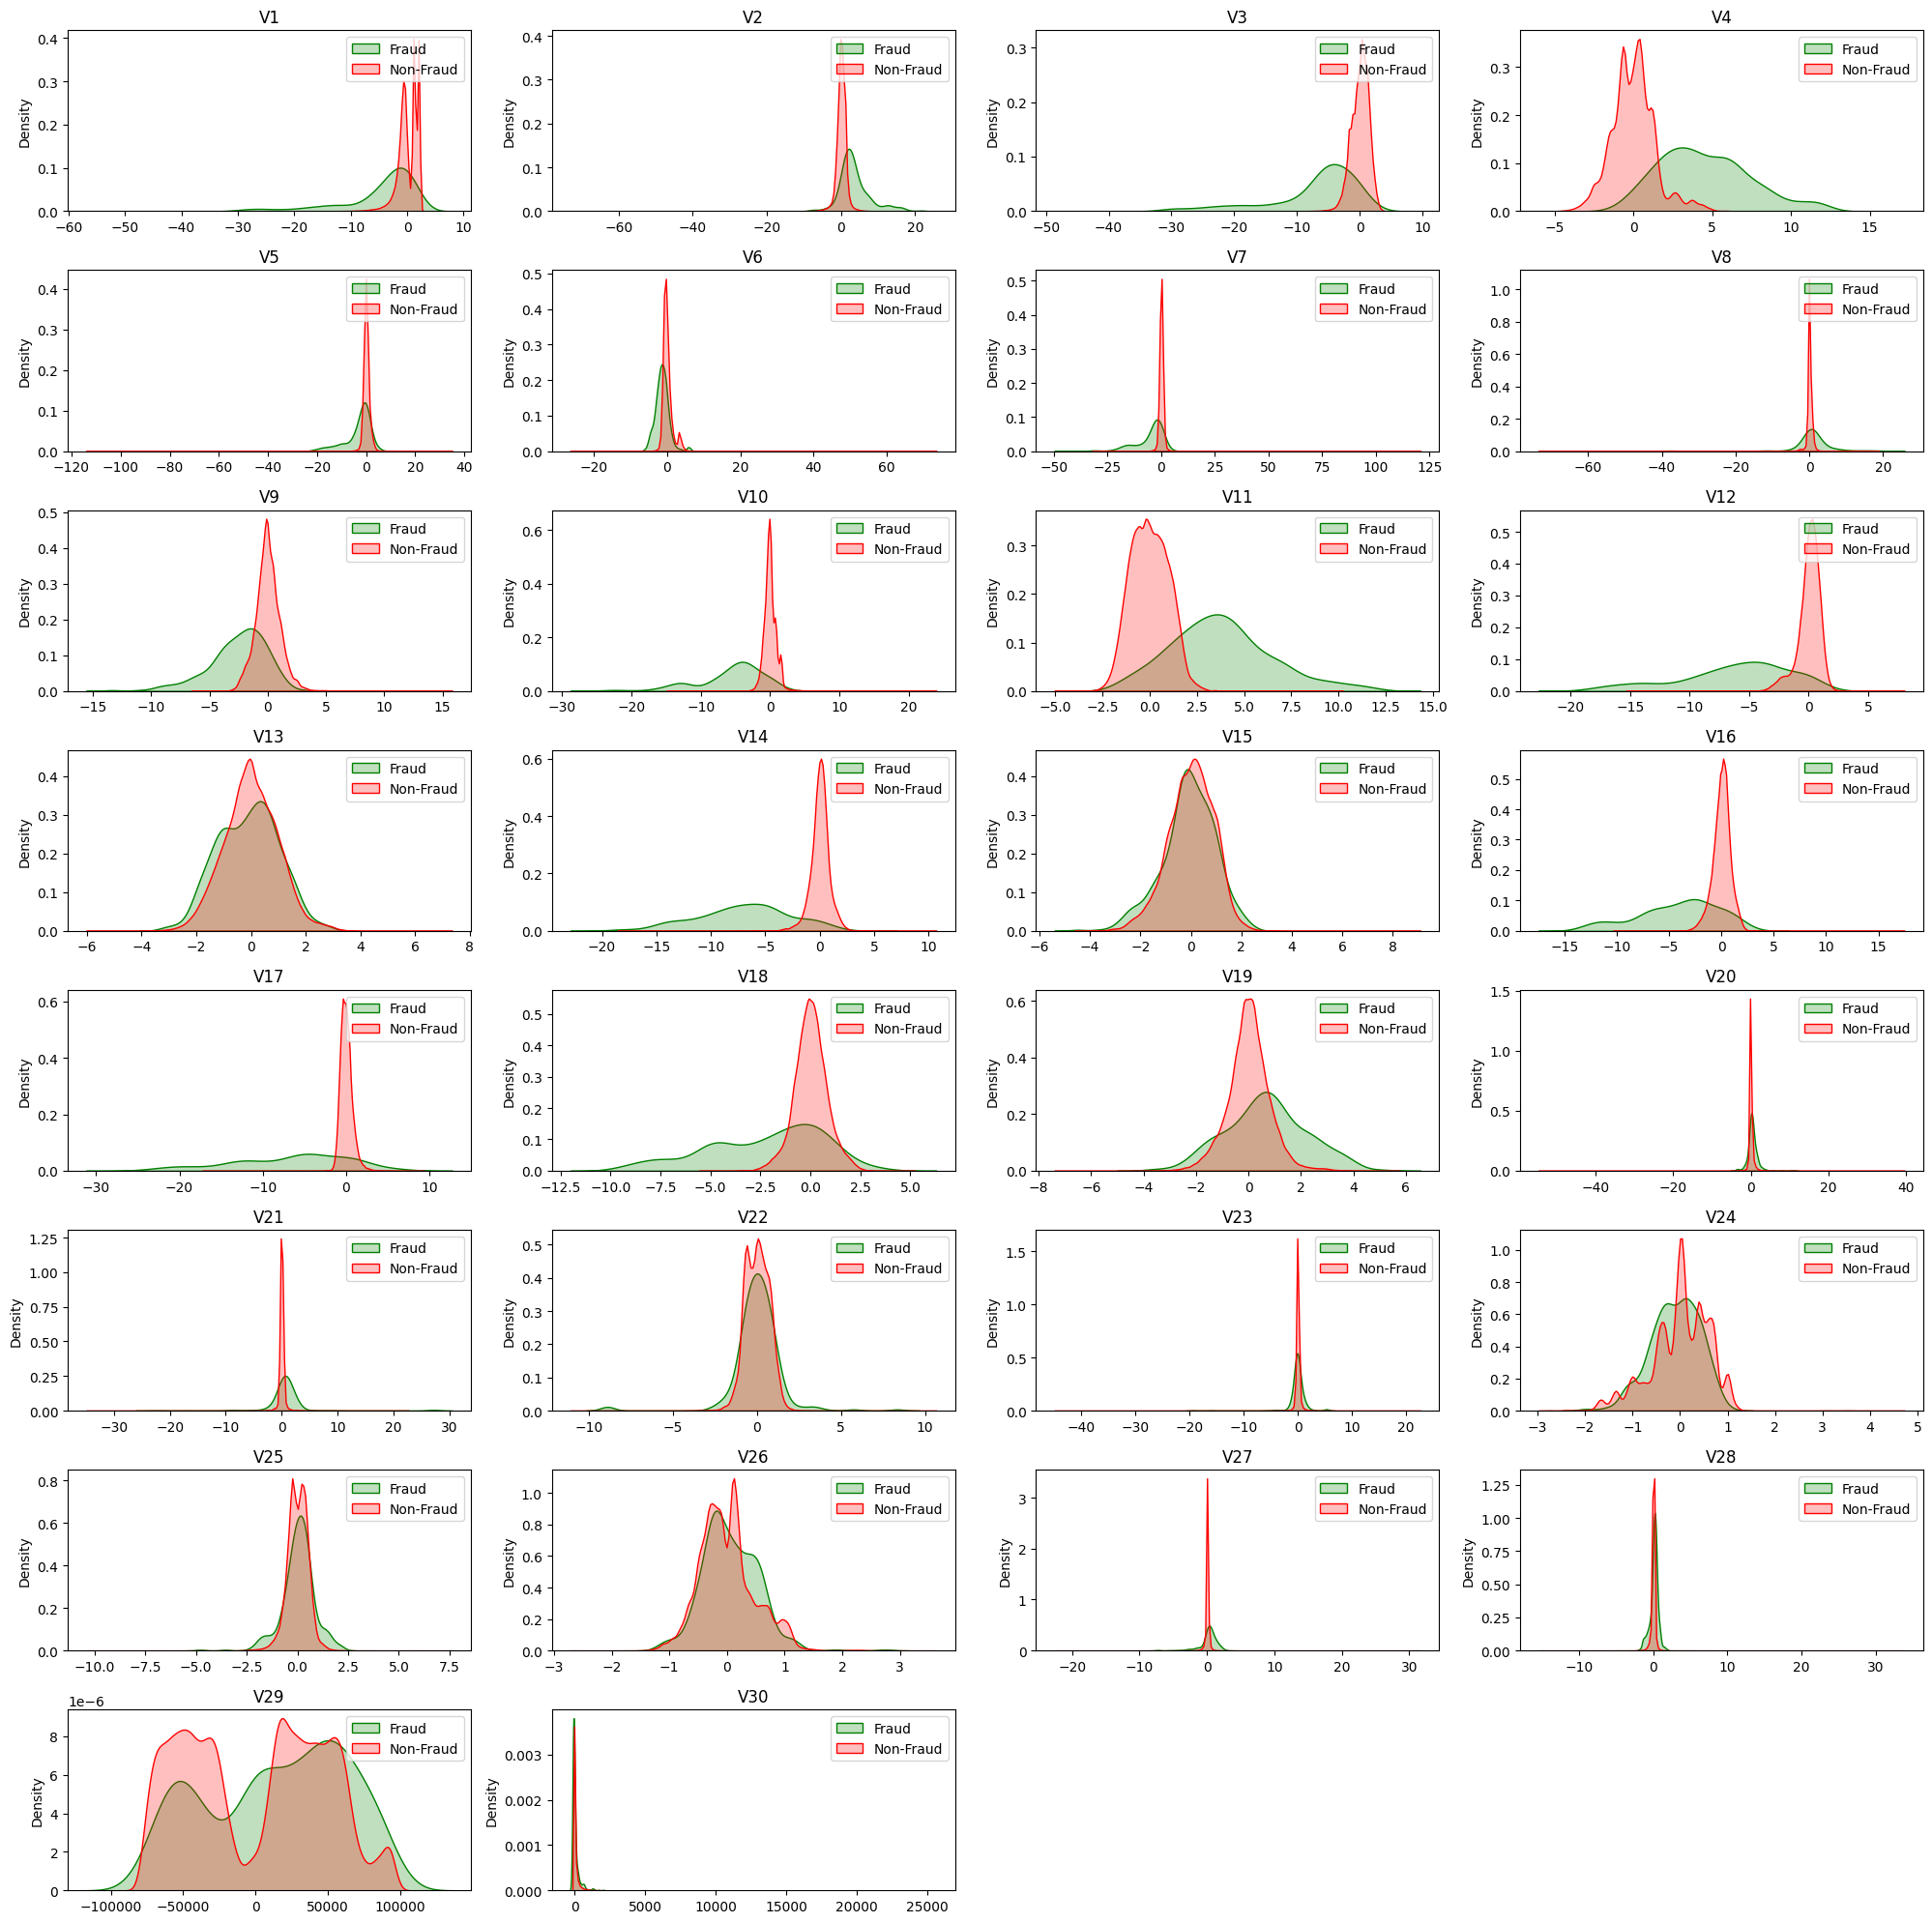

In [12]:
sample_columns = df.drop('Class', axis=1).columns


n_cols = 4  
n_rows = (len(sample_columns) + n_cols - 1) // n_cols  

plt.figure(figsize=(20,10*2))  

for n, col in enumerate(sample_columns, 1):
    plt.subplot(n_rows, n_cols, n)  
    sns.kdeplot(df[df['Class'] == 1][col], color='g', label='Fraud', fill=True)
    sns.kdeplot(df[df['Class'] == 0][col], color='r', label='Non-Fraud', fill=True)
    plt.ylabel('Density')
    plt.title(col)
    plt.xlabel('')
    plt.legend()


plt.tight_layout()
plt.show()


## Feature Selection using Z-test

Lets move to do some hypothesis testing to find statistically significant features. We will be performing `Z-test` with valid transactions as our population. 

So the case is we have to find if the values of fraud transactions are significantly different from normal transaction or not for all features. The level of significance is 0.01 and its a two tailed test.

#### Scenario:
* Valid transactions as our population
* Fraud transactions as sample
* Two tailed Z-test
* Level of significance 0.01
* Corresponding critical value is 2.58

#### Hypothesis:
* H0: There is no difference (insignificant)
* H1: There is a difference  (significant)

#### Formula for z-score:

$$ Zscore = (\bar{x} - \mu) / S.E$$

In [13]:
def ztest(feature):
    mean = normal[feature].mean()
    std = fraud[feature].std()
    zScore = (fraud[feature].mean() - mean) / (std / np.sqrt(sample_size))
    return zScore

In [14]:
columns = df.drop('Class', axis=1).columns
normal = df[df.Class == 0]
fraud = df[df.Class == 1]
sample_size = len(fraud)


significant_features = []
critical_value = 2.58  # Corresponds to a significance level of 0.01 for a two-tailed test

# Perform z-test for each feature
for feature in columns:
    z_value = ztest(feature)
    
    if abs(z_value) >= critical_value:
        print(f"{feature} is statistically significant (Reject Null Hypothesis, H0).")
        significant_features.append(feature)
    else:
        print(f"{feature} is NOT statistically significant (Fail to Reject Null Hypothesis, H0).")

# Summary
print("\nSignificant Features:")
print(significant_features)


V1 is statistically significant (Reject Null Hypothesis, H0).
V2 is statistically significant (Reject Null Hypothesis, H0).
V3 is statistically significant (Reject Null Hypothesis, H0).
V4 is statistically significant (Reject Null Hypothesis, H0).
V5 is statistically significant (Reject Null Hypothesis, H0).
V6 is statistically significant (Reject Null Hypothesis, H0).
V7 is statistically significant (Reject Null Hypothesis, H0).
V8 is NOT statistically significant (Fail to Reject Null Hypothesis, H0).
V9 is statistically significant (Reject Null Hypothesis, H0).
V10 is statistically significant (Reject Null Hypothesis, H0).
V11 is statistically significant (Reject Null Hypothesis, H0).
V12 is statistically significant (Reject Null Hypothesis, H0).
V13 is NOT statistically significant (Fail to Reject Null Hypothesis, H0).
V14 is statistically significant (Reject Null Hypothesis, H0).
V15 is NOT statistically significant (Fail to Reject Null Hypothesis, H0).
V16 is statistically signifi

In [15]:
significant_features.append('Class')
df= df[significant_features]

<a id="1"></a>
# <div style="text-align:center; border-radius:25px 70px; padding:9px; color:white; margin:0; font-size:150%; font-family:Pacifico; background-color:#0566D5; overflow:hidden"><b>Feature Transformation</b></div>

## Feature Transformation for Anomaly Detection

Feature transformation plays a crucial role in enhancing the performance of anomaly detection algorithms. Many of these techniques assume that the data follows a **Gaussian (normal) distribution**. When features are skewed (i.e., having long tails in one direction) or exist on different scales, anomaly detection models may struggle to distinguish between normal data points and anomalies. This misalignment can result in **normal instances being flagged as outliers** or **genuine anomalies being overlooked**.

### Addressing Skewness:
Upon examining our histogram plots, we observe that many of the features are highly skewed. To tackle this issue, we plan to apply **log transformations**. This transformation will:
- **Stabilize variance** across features.
- **Reduce skewness**, making the distribution more symmetric.
- Improve **interpretability** of the data.

By aligning the data closer to the assumptions of the anomaly detection models, this transformation enhances the models' ability to identify true anomalies and increases the overall reliability of the detection process.


As we can see that data distribution of normal and fraud cases of some features like **V20, V25** are overlapping and they seem same. Such features are not good at differentiating between normal and fraud transactions.

In [16]:
features = df.columns[:-1]
df_transformed = df.copy()


def log_transform_skewed(column):
    transformed = np.where(column >= 0, np.log1p(column), -np.log1p(-column))
    return transformed


skewness_before = df.skew()

for col in features:
    if abs(df[col].skew()) > 0.75:  
        df_transformed[col] = log_transform_skewed(df[col])


skewness_after = df_transformed.skew()

skewness_comparison = pd.DataFrame({
    'Skewness Before': skewness_before,
    'Skewness After': skewness_after
})

skewness_comparison

,Skewness Before,Skewness After
V1,-3.280667,-0.364893
V2,-4.624866,-0.310128
V3,-2.240155,-0.315192
V4,0.676292,0.676292
V5,-2.425901,0.139077
V6,1.826581,0.804345
V7,2.553907,-0.112666
V9,0.554680,0.554680
V10,1.187141,0.420549
V11,0.356506,0.356506


- **As we can see, after the log transformation, the skewness is no longer present.**

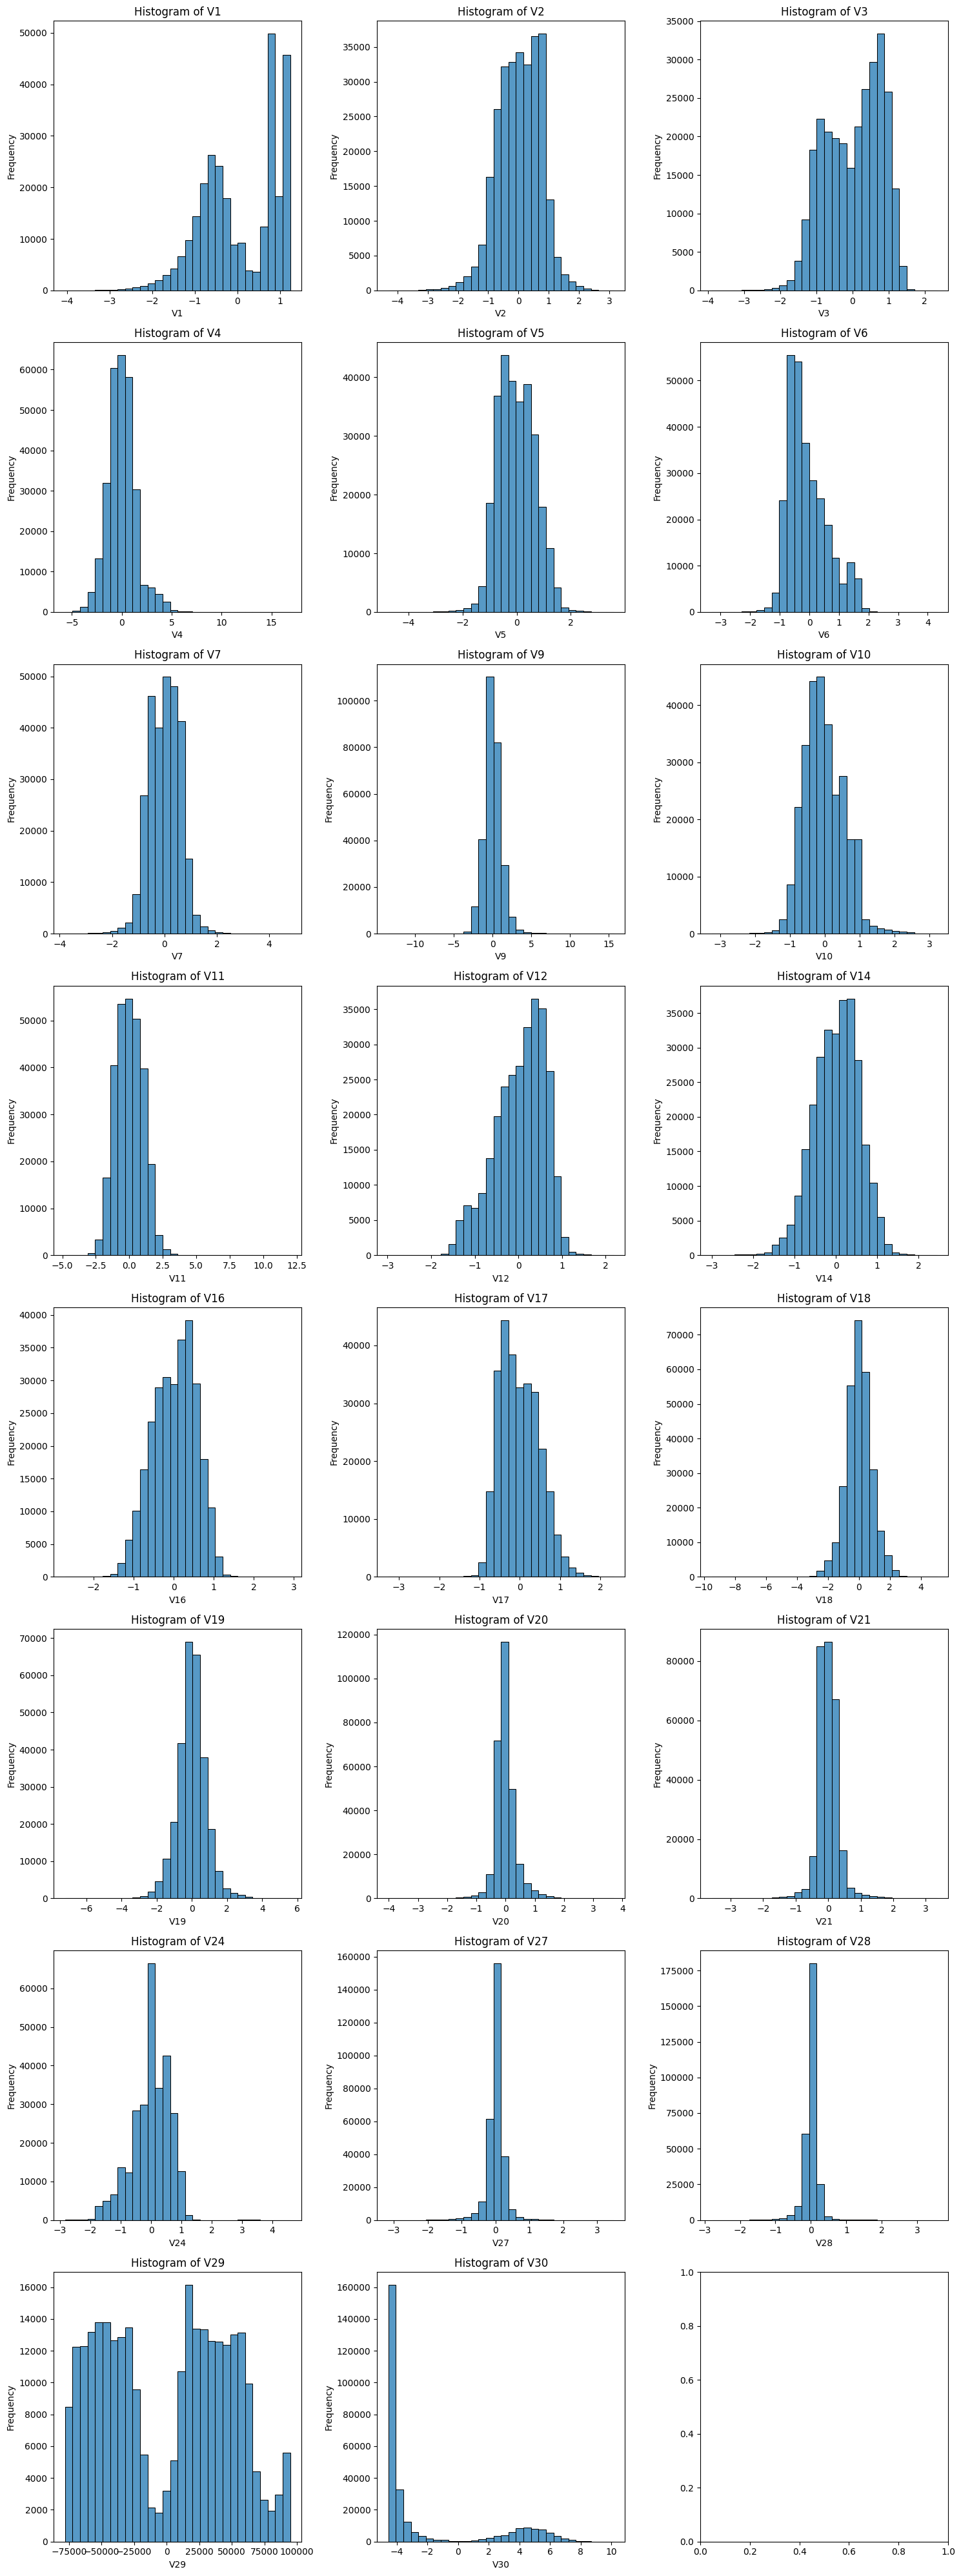

In [17]:
features = df.columns[:-1]
fig, axes = plt.subplots(8, 3, figsize=(15, 40))  

# Flatten axes array to loop through easily
axes = axes.flatten()


for i, feature in enumerate(features):
    sns.histplot(df_transformed[feature], ax=axes[i], kde=False, bins=30)
    axes[i].set_title(f'Histogram of {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## Scaling Features

In [18]:
X = df_transformed[features]
y = df_transformed.Class

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

<a id="1"></a>
# <div style="text-align:center; border-radius:25px 70px; padding:9px; color:white; margin:0; font-size:150%; font-family:Pacifico; background-color:#0566D5; overflow:hidden"><b>Isolation Forest</b></div>

![iso](https://machinelearninggeek.com/wp-content/uploads/2020/10/image-78.png)

## 🌲 Isolation Forest

Isolation Forest is an **unsupervised machine learning algorithm** used for outlier detection. It works by building an ensemble of **isolation trees**, which are binary trees that randomly partition the data points. Anomalies, or outliers, are easier to isolate because they tend to have shorter path lengths in the trees, making them stand out from the majority of normal data points.

### How It Works:
- **Random Splits**: Isolation Forest randomly selects features and splits data points at random values. The idea is that anomalies, being rare and different, will be isolated faster with fewer splits.
- **Path Lengths**: Anomalies are expected to have **shorter average path lengths** compared to normal data points, making them easier to isolate. The algorithm assigns **anomaly scores** based on these path lengths, identifying outliers as points with low scores.

### Strengths:
- **Effective for Large Datasets**: Isolation Forest is fast and scales well, making it suitable for high-dimensional datasets.
- **No Assumptions**: It does not make assumptions about the underlying data distribution, making it versatile for various types of data.
- **Handling High Dimensions**: It works well with high-dimensional data, which can be a challenge for many other anomaly detection algorithms.

### Limitations:
- **Misses Complex Patterns**: Since it relies on random splits, it might miss complex patterns and relationships in the data. Anomalies that are similar to normal points might not be detected effectively.

In summary, Isolation Forest is a highly efficient and scalable technique for anomaly detection, especially in large and high-dimensional datasets, though it may struggle with more complex data patterns.


In [19]:
# Initialize the Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=101)   # high contamination to catch more fraud transactions

# Fit the model and predict (returns -1 for anomalies and 1 for normal data)
iso_preds = iso_forest.fit_predict(X_scaled)

# Convert -1 (anomalies) to 1 (fraud) and 1 (normal) to 0 (non-fraud)
iso_preds = [1 if x == -1 else 0 for x in iso_preds]

# Evaluate the results
print(classification_report(y, iso_preds))
roc_auc = roc_auc_score(y, iso_preds)
print("ROC AUC Score: ", roc_auc)

              precision    recall  f1-score   support

           0       1.00      0.95      0.97    284315
           1       0.03      0.87      0.06       492

    accuracy                           0.95    284807
   macro avg       0.51      0.91      0.52    284807
weighted avg       1.00      0.95      0.97    284807

ROC AUC Score:  0.9086315933503847


- **high contamination to catch more fraud transactions**

In [20]:
def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):

    cm = confusion_matrix(y_true, y_pred)
    

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
    

    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.xticks([0.5, 1.5], ['Non-Fraud (0)', 'Fraud (1)'])
    plt.yticks([0.5, 1.5], ['Non-Fraud (0)', 'Fraud (1)'])
    
    # Display the plot
    plt.show()

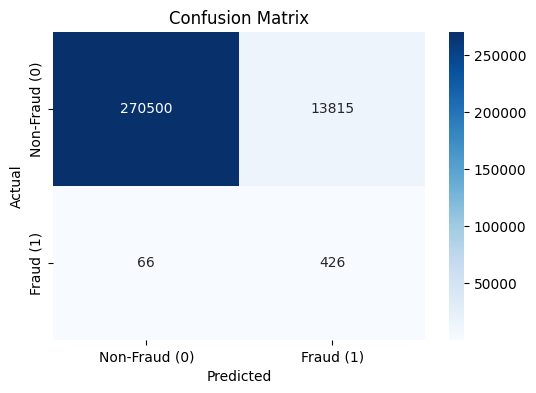

In [21]:
plot_confusion_matrix(y, iso_preds)

<a id="1"></a>
# <div style="text-align:center; border-radius:25px 70px; padding:9px; color:white; margin:0; font-size:150%; font-family:Pacifico; background-color:#0566D5; overflow:hidden"><b>One-Class SVM</b></div>

## Support Vector Machine (SVM)

**SVM (Support Vector Machine)** is a supervised machine learning algorithm primarily used for **classification** and **regression** tasks. The goal of SVM is to find the **optimal hyperplane** that separates data points into different classes or predicts continuous values. It works by maximizing the margin between different classes, which makes it **robust to outliers**. 

### Key Features of SVM:
- **Linear and Non-linear Classification**: SVM can handle linearly separable data and, through the use of **kernels**, it can also tackle non-linearly separable data by mapping it into a higher-dimensional feature space.
- **Effective in High-Dimensional Spaces**: SVM is highly effective for datasets with a large number of features (high-dimensional spaces).
- **Computational Complexity**: While powerful, SVM can be computationally expensive for large datasets due to its **quadratic time complexity**.

---

## One-Class SVM

**One-Class SVM** is a variation of the SVM model designed for **anomaly detection**. It works by learning the boundary of **normal data points** and flags any data points that fall outside this boundary as **anomalies**. This model is particularly useful in **high-dimensional spaces**, where traditional anomaly detection methods may struggle.

### Key Points About One-Class SVM:
- **Boundary Detection**: One-Class SVM creates a boundary around normal data and detects anomalies as points that do not conform to the learned boundary.
- **High-Dimensional Data**: It is effective in high-dimensional spaces where detecting anomalies with traditional methods can be challenging.
- **Computationally Intensive**: The model can be **sensitive to noise** in the data, which may lead to misclassification of outliers as normal data points. Additionally, it can be computationally expensive, especially for large datasets.

<img src="https://www.researchgate.net/publication/345644388/figure/fig1/AS:1024147857620994@1621187285679/Overview-of-one-class-Support-Vector-Machine-SVM.png" height=60% width=60% style="text-align:center;">

In [22]:
oc_svm = OneClassSVM(kernel='rbf', gamma=0.001, nu=0.05)


svm_preds = oc_svm.fit_predict(X_scaled)


svm_preds = [1 if x == -1 else 0 for x in svm_preds]


print(classification_report(y, svm_preds))
roc_auc = roc_auc_score(y, svm_preds)
print("ROC AUC Score: ", roc_auc)
print("Confusion Matrix:")

              precision    recall  f1-score   support

           0       1.00      0.95      0.97    284315
           1       0.03      0.87      0.06       492

    accuracy                           0.95    284807
   macro avg       0.51      0.91      0.52    284807
weighted avg       1.00      0.95      0.97    284807

ROC AUC Score:  0.9096513707385988
Confusion Matrix:


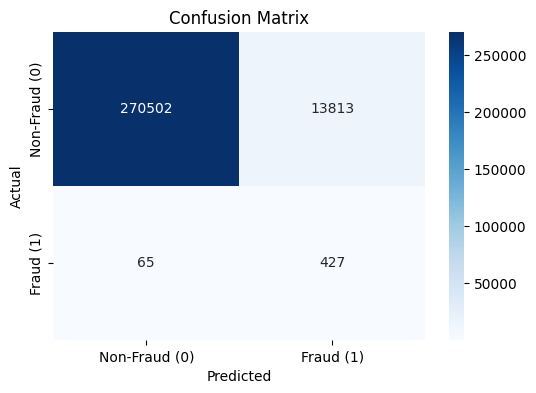

In [23]:
cm = confusion_matrix(y, svm_preds)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')  


plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0.5, 1.5], ['Non-Fraud (0)', 'Fraud (1)'])
plt.yticks([0.5, 1.5], ['Non-Fraud (0)', 'Fraud (1)'])
plt.show()

<a id="1"></a>
# <div style="text-align:center; border-radius:25px 70px; padding:9px; color:white; margin:0; font-size:150%; font-family:Pacifico; background-color:#0566D5; overflow:hidden"><b>Local Outlier Factor (LOF)</b></div>

## Local Outlier Factor (LOF)

**LOF (Local Outlier Factor)** is an **unsupervised anomaly detection** algorithm that identifies anomalies by assessing the **local density deviation** of a data point compared to its neighbors. It quantifies the abnormality of a data point based on how much its local density differs from the densities of surrounding points.

### How LOF Works:
- The LOF algorithm calculates a **local reachability density** for each data point. This density represents how isolated or tightly grouped the point is compared to its neighbors.
- **Anomaly scores** are then assigned based on the **degree of density deviation**. If a point's density is significantly lower than that of its neighbors, it is flagged as an outlier with a higher LOF score.

### Key Features of LOF:
- **Effective for Varying Densities**: LOF works well for identifying anomalies in datasets with **clusters of varying densities**.
- **Local Perspective**: It provides a **local view** of the data, allowing for more nuanced anomaly detection, especially when anomalies exist in areas of the data with different densities.
- **No Assumptions About Data Distribution**: Unlike some methods, LOF doesn't rely on strict assumptions about the underlying data distribution.
  
### Considerations:
- **Sensitive to Neighbors**: The performance of LOF can be **sensitive** to the choice of the **number of neighbors**. This parameter can affect its ability to correctly identify anomalies.
  
### Use Cases:
- **Complex Data Structures**: LOF is ideal for datasets that have **complex structures**, where traditional anomaly detection methods might struggle.
- **Clustering Anomalies**: It is particularly useful for detecting outliers in **clusters** of data points with varying densities.

---
**LOF** is a powerful and flexible tool for anomaly detection, especially when the data is not uniformly distributed or has irregular clusters.

<img src="https://www.googleapis.com/download/storage/v1/b/kaggle-forum-message-attachments/o/inbox%2F1341832%2F27b93ecfd56afa80040f9b1ebecccbed%2F1_217TN2_-cgZ1d7hZUWhYUA.png?generation=1600286513104059&alt=media" height=45% width=45% style="text-align:center;">

In [24]:
lof = LocalOutlierFactor(n_neighbors=10, contamination=0.05)


lof_preds = lof.fit_predict(X_scaled)


lof_preds = [1 if x == -1 else 0 for x in lof_preds]

# Evaluate the results
print(classification_report(y, lof_preds))
roc_auc = roc_auc_score(y, lof_preds)
print("ROC AUC Score: ", roc_auc)
print("Confusion Matrix:")
print(confusion_matrix(y, lof_preds))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97    284315
           1       0.00      0.11      0.01       492

    accuracy                           0.95    284807
   macro avg       0.50      0.53      0.49    284807
weighted avg       1.00      0.95      0.97    284807

ROC AUC Score:  0.5309466276740744
Confusion Matrix:
[[270129  14186]
 [   437     55]]


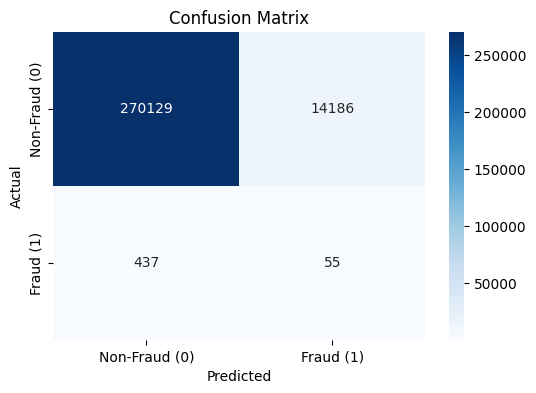

In [25]:
plot_confusion_matrix(y, lof_preds)

<a id="1"></a>
# <div style="text-align:center; border-radius:25px 70px; padding:9px; color:white; margin:0; font-size:150%; font-family:Pacifico; background-color:#0566D5; overflow:hidden"><b>DBSCAN</b></div>

## DBSCAN (Density-Based Spatial Clustering of Applications with Noise)

**DBSCAN** is a **density-based clustering algorithm** that groups data points based on their density. It identifies **clusters of similar points** and flags isolated points as **anomalies** or **noise**. This method is particularly effective for detecting **irregularly shaped clusters** and handling **noise** in datasets.

### How DBSCAN Works:
- **Core Points**: A data point is considered a core point if it has at least a specified number of points (minPts) within a given **distance threshold (ε)**.
- **Border Points**: Points that are not core points but fall within the neighborhood of a core point.
- **Noise Points**: Points that do not meet the criteria for being core or border points are classified as noise, effectively being marked as anomalies.

### Key Features of DBSCAN:
- **Effective for Irregular Clusters**: DBSCAN can identify clusters with arbitrary shapes, making it useful for data that doesn't follow traditional spherical clusters.
- **Handles Noise Well**: It can handle noise in the dataset by labeling outliers as noise points.
- **No Need to Predefine the Number of Clusters**: Unlike methods like k-Means, DBSCAN does not require specifying the number of clusters in advance.

### Considerations:
- **Parameter Sensitivity**: DBSCAN requires the setting of two parameters: the distance threshold (**ε**) and the minimum number of points (**minPts**) for a point to be considered a core point. Choosing the right values for these parameters is crucial and can significantly affect the clustering results.
- **Performance on Varying Densities**: DBSCAN might struggle with datasets containing clusters of varying densities, as it assumes clusters to be of similar density.

### Use Cases:
- **Anomaly Detection**: DBSCAN is well-suited for anomaly detection in datasets with irregular clusters and noise, as it can effectively isolate outliers.
- **Geospatial Data**: Commonly used for clustering in spatial data, such as identifying clusters of locations in maps.
  
---
**DBSCAN** is a robust algorithm for detecting anomalies and clustering in complex datasets, especially when dealing with noise or irregularly shaped clusters.

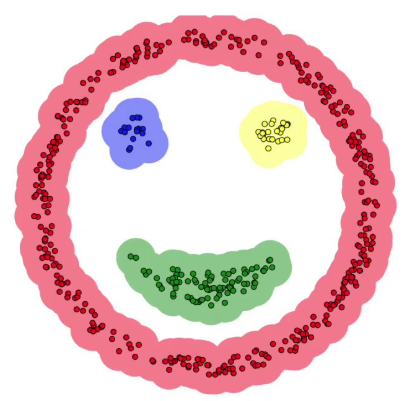

In [26]:
dbscan = DBSCAN(eps=0.5, min_samples=5)

# Fit and predict (labels different clusters, outliers labeled as -1)
dbscan_preds = dbscan.fit_predict(X_scaled)

# Convert -1 (anomalies) to 1 (fraud) and others to 0 (non-fraud)
dbscan_preds = [1 if x == -1 else 0 for x in dbscan_preds]

# Evaluate the results
print(classification_report(y, dbscan_preds))
roc_auc = roc_auc_score(y, dbscan_preds)
print("ROC AUC Score: ", roc_auc)
print("Confusion Matrix:")
print(confusion_matrix(y, dbscan_preds))

              precision    recall  f1-score   support

           0       1.00      0.26      0.41    284315
           1       0.00      0.92      0.00       492

    accuracy                           0.26    284807
   macro avg       0.50      0.59      0.21    284807
weighted avg       1.00      0.26      0.41    284807

ROC AUC Score:  0.5898580084582128
Confusion Matrix:
[[ 74211 210104]
 [    40    452]]


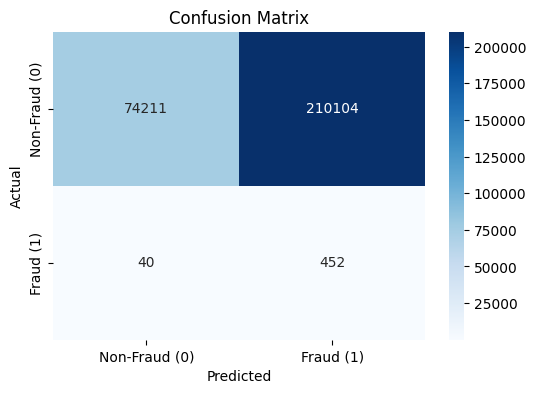

In [27]:
plot_confusion_matrix(y, dbscan_preds)

<a id="1"></a>
# <div style="text-align:center; border-radius:25px 70px; padding:9px; color:white; margin:0; font-size:150%; font-family:Pacifico; background-color:#0566D5; overflow:hidden"><b> Conclusions</b></div>

# Fraud Detection Model Analysis

Most models prioritized capturing as many fraudulent transactions as possible, resulting in **high recall for fraud (class 1)** but at the cost of flagging many non-fraudulent transactions as fraud. ⚠️ This trade-off explains the **high recall and low precision** for fraud detection across models. While some degree of this is unavoidable, the goal remains to **balance these metrics** ⚖️.

---

## **Model Performance Breakdown**

### **🔗 DBSCAN**
- **Achieved the highest recall**, flagging **92% of frauds** 🚨, which is impressive.
- **However**, the confusion matrix reveals that **most transactions were flagged as fraud**.
- Given that fraud accounts for only **0.2% of transactions**, this leads to:
  - **High cost** 💸
  - **Significant inconvenience for customers**
- **Conclusion**: This makes DBSCAN an **impractical solution** for fraud detection.

---

### **🔄 One-Class SVM and Isolation Forest**
- **Captured around 87% of frauds** 🔍 while predicting fewer overall frauds.
- **Struck a better balance** between:
  - Identifying fraud
  - Minimizing false positives
- **Result**: A **more practical approach** for fraud detection with fewer unnecessary disruptions ✅.

---

## **Key Takeaways**
- **High recall** is important for fraud detection, but it often comes at the cost of **low precision**.
- **DBSCAN** achieves exceptional recall but is impractical due to excessive false positives.
- **One-Class SVM and Isolation Forest** provide a better balance, making them more suitable for real-world applications.

---

## **Recommendations**
- **Focus on balancing recall and precision** to minimize false positives while still capturing a significant portion of fraud.
- **Consider the business cost** of false positives, as they can lead to customer dissatisfaction and operational inefficiencies.
- **Experiment with hybrid approaches** or ensemble methods to further optimize the trade-off between recall and precision.

**Thank you for taking the time to read through this notebook. I appreciate your attention and hope the insights shared here are useful for your projects.**

**Feel free to leave any feedback or suggestions**